In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

## Import and Split data

In [2]:
df_features = pd.read_csv('dengue_features_train.csv')
df_labels = pd.read_csv('dengue_labels_train.csv')

In [3]:
data = pd.merge(df_features, df_labels, on = ['city','year','weekofyear'], how = 'left')
data["week_start_date"] = pd.to_datetime(data["week_start_date"])

In [4]:
data.shape

(1456, 25)

In [ ]:
data.info()

In [ ]:
data.isna().sum()

In [5]:
sj = data[data.city == 'sj']
iq = data[data.city == 'iq']

In [6]:
sj = sj.drop(['city','year','weekofyear',],axis=1).set_index('week_start_date')
iq = iq.drop(['city','year','weekofyear',],axis=1).set_index('week_start_date')

In [7]:
print(sj.shape)
print(iq.shape)

(936, 21)
(520, 21)


In [8]:
# 8 : 2 train test split(adjust a bit for forward fillna)
sj_test_size = 190
iq_test_size = 108

sj_train, sj_test = sj[:-sj_test_size], sj[-sj_test_size:]
iq_train, iq_test = iq[:-iq_test_size], iq[-iq_test_size:]

In [10]:
# Forward fill NA values
sj_train.fillna(method='ffill')
iq_train.fillna(method='ffill')

sj_test.fillna(method='ffill')
iq_test.fillna(method='ffill')

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-06-03,0.195186,0.157714,0.184429,0.133614,30.09,296.400000,297.357143,295.210000,304.4,292.2,...,93.982857,30.09,16.711429,6.771429,26.900000,7.550000,31.1,20.4,13.6,1
2008-06-10,0.293743,0.264367,0.246629,0.291957,13.27,296.187143,297.364286,293.891429,305.8,288.2,...,88.810000,13.27,15.375714,9.300000,26.900000,7.550000,31.1,17.8,6.4,0
2008-06-17,0.224029,0.175471,0.265657,0.245214,111.18,296.742857,297.650000,295.934286,304.4,293.8,...,95.860000,111.18,17.447143,6.957143,26.900000,7.550000,31.1,21.0,79.8,0
2008-06-24,0.197043,0.277983,0.213943,0.265614,89.88,296.458571,297.250000,295.192857,304.8,291.2,...,93.795714,89.88,16.712857,7.385714,26.900000,7.550000,31.1,18.0,93.5,1
2008-07-01,0.304829,0.233671,0.248914,0.255814,0.00,296.542857,297.807143,293.830000,304.9,290.7,...,86.524286,0.00,15.285714,9.442857,26.900000,7.550000,31.1,20.8,1.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1


In [11]:
sj_labels = sj[['total_cases']]
iq_labels = iq[['total_cases']]

In [30]:
# 分离特征和标签
def split_features_labels(data):
    return data.drop('total_cases', axis=1), data[['total_cases']].values.ravel()

sj_train_features, sj_train_labels = split_features_labels(sj_train)
sj_test_features, sj_test_labels = split_features_labels(sj_test)

iq_train_features, iq_train_labels = split_features_labels(iq_train)
iq_test_features, iq_test_labels = split_features_labels(iq_test)

In [ ]:
# print ('San Juan')
# print ('Shape of training features:',sj_train_features.shape)
# print ('Shape of training labels:',sj_train_labels.shape)
# print ('Shape of test features:',sj_test_features.shape)
# print ('Shape of test labels:',sj_test_labels.shape)

# print ('Iquitos')
# print ('Shape of training features:',iq_train_features.shape)
# print ('Shape of training labels:',iq_train_labels.shape)
# print ('Shape of test features:',iq_test_features.shape)
# print ('Shape of test labels:',iq_test_labels.shape)

## Feature Selection

In [80]:
# RFR_ = RFR(n_estimators =6,random_state=0)
# X = sj_train_features
# y = sj_train_labels

# X_embedded = SelectFromModel(RFR_,threshold=0.03).fit_transform(X,y)

# X_embedded.shape

(746, 4)

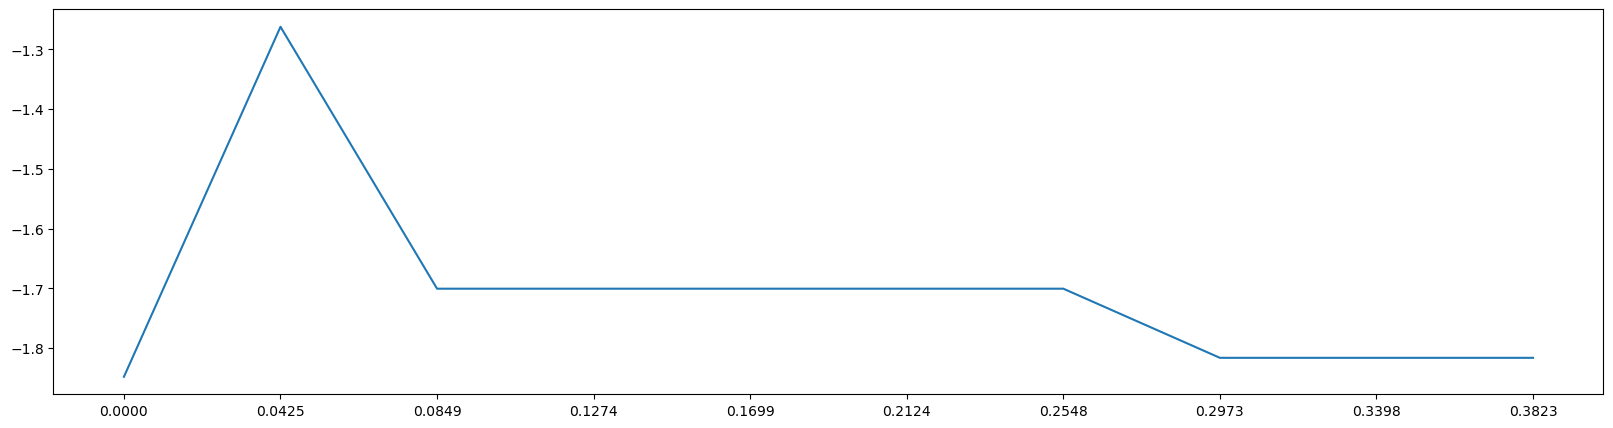

In [83]:
# threshold = np.linspace(0, (RFR_.fit(X, y).feature_importances_).max(), 10)

# score = []
# for i in threshold:
#     X_embedded = SelectFromModel(RFR_, threshold=i).fit_transform(X, y)
#     once = cross_val_score(RFR_, X_embedded, y, cv=5).mean()
#     score.append(once)
# plt.figure(figsize=(20, 5))
# plt.plot(threshold, score)
# plt.xticks(threshold)
# plt.show()

## Random forest

### SJ

In [ ]:
# sj_train1 = sj_train.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"])
# sj_test1 = sj_test.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"]) 
# iq_train1 = iq_train.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"])
# iq_test1 = iq_test.drop(columns = ["reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_sat_precip_amt_mm","reanalysis_specific_humidity_g_per_kg"]) 

In [52]:
X_train = sj_train_features
y_train = sj_train_labels
X_test = sj_test_features

In [53]:
# Features to be normalized
features_to_normalize = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
                         'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'station_avg_temp_c',
                         'station_max_temp_c', 'station_min_temp_c']

# Features to be scaled
features_to_scale = ['station_diur_temp_rng_c', 'reanalysis_tdtr_k', 'precipitation_amt_mm',
                     'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent',
                     'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg',
                     'station_precip_mm']

sc = StandardScaler()
# Fit and transform the scaler to the features to be scaled in both training and testing sets
X_train[features_to_scale] = sc.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = sc.transform(X_test[features_to_scale])

minmax = MinMaxScaler()
# Fit and transform the minmax scaler to the features to be normalized in both training and testing sets
X_train[features_to_normalize] = minmax.fit_transform(X_train[features_to_normalize])
X_test[features_to_normalize] = minmax.transform(X_test[features_to_normalize])

In [74]:
rfr = RFR(n_estimators=5)
rfr.fit(X_train, y_train)
pred_rfr = rfr.predict(X_test)
print(mean_absolute_error(sj_test_labels, pred_rfr))

28.955263157894738


In [63]:
#之后再补充 GridSearchCV和variable importance

### IQ

In [85]:
X_train = iq_train_features
y_train = iq_train_labels
X_test = iq_test_features

In [86]:
sc = StandardScaler()
# Fit and transform the scaler to the features to be scaled in both training and testing sets
X_train[features_to_scale] = sc.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = sc.transform(X_test[features_to_scale])

minmax = MinMaxScaler()
# Fit and transform the minmax scaler to the features to be normalized in both training and testing sets
X_train[features_to_normalize] = minmax.fit_transform(X_train[features_to_normalize])
X_test[features_to_normalize] = minmax.transform(X_test[features_to_normalize])

In [88]:
rfr = RFR(n_estimators=5)
rfr.fit(X_train, y_train)
pred_rfr = rfr.predict(X_test)
print(mean_absolute_error(iq_test_labels, pred_rfr))

8.32962962962963
